In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes scipy torch trl
!pip install -q tensorboard

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -U bitsandbytes

In [ ]:
import pandas as pd
import torch
from datasets import Dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
import warnings
warnings.filterwarnings('ignore')
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
logging.set_verbosity_info()
import os

# Force CUDA synchronous error reporting for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Model Configuration
MODEL_NAME = "meta-llama/Llama-3.2-3B"  # 3B parameter model - good balance of size and performance
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/finetune_llama/output_llama_2"

# LoRA Configuration - optimized for Google Colab free GPU
LORA_ALPHA = 16
LORA_DROPOUT = 0.1
LORA_R = 8  # Reduced rank for faster training

DATASET_PATHS = [
    "/content/dataset2.csv"
]

def prepare_dataset(dataset_path):
    try:
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded from {dataset_path} with shape: {df.shape}")
        print(df.head())

        if all(col in df.columns for col in ['Question', 'Answer']):
            df_filtered = df[['Question', 'Answer']]
        elif all(col in df.columns for col in ['question', 'answer']):
            df_filtered = df[['question', 'answer']]
            df_filtered = df_filtered.rename(columns={"question": "Question", "answer": "Answer"})
        else:
            raise ValueError(f"Dataset {dataset_path} doesn't have the required Question/Answer columns")

        # Clean the data - remove NaN values and convert to strings
        df_filtered = df_filtered.dropna()
        df_filtered['Question'] = df_filtered['Question'].astype(str)
        df_filtered['Answer'] = df_filtered['Answer'].astype(str)

        # Filter out very long sequences that might cause issues
        df_filtered = df_filtered[
            (df_filtered['Question'].str.len() < 1000) &
            (df_filtered['Answer'].str.len() < 1000)
        ]

        dataset_dict = {
            "question": df_filtered["Question"].tolist(),
            "answer": df_filtered["Answer"].tolist()
        }
        return Dataset.from_dict(dataset_dict)
    except Exception as e:
        print(f"Error loading dataset from {dataset_path}: {e}")
        return None

# Load and prepare datasets
datasets = []
for path in DATASET_PATHS:
    dataset = prepare_dataset(path)
    if dataset is not None:
        datasets.append(dataset)
        print(f"Successfully loaded dataset from {path} with {len(dataset)} examples")

if not datasets:
    raise ValueError("No valid datasets were loaded. Please check your dataset paths and formats.")

combined_dataset = datasets[0] if len(datasets) == 1 else concatenate_datasets(datasets)
combined_dataset = combined_dataset.shuffle(seed=42)

# Display sample examples
for i in range(min(5, len(combined_dataset))):
    print(f"--- Example {i+1} ---")
    print("Question:", combined_dataset[i]['question'])
    print("Answer:", combined_dataset[i]['answer'])
    print()

# Login to Hugging Face
from getpass import getpass
from huggingface_hub import login
hf_token = getpass("Enter your Hugging Face token: ")
login(hf_token)

# Initialize tokenizer with proper configuration
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    use_fast=True,
    padding_side="left"  # Changed to left for LLaMA models
)

# Set pad token properly - crucial for avoiding CUDA errors
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")

# Configure quantization for efficient training
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Load the model with optimized configuration
print("Loading model. This may take a few minutes...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_cache=False,  # Disable KV cache for training
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)


GPU available: True
CUDA device: Tesla T4
Dataset loaded from /content/dataset2.csv with shape: (20079, 4)
                                               input  \
0  I'm finding it hard to low self-esteem and fee...   
1  I'm overwhelmed by lack of motivation and feel...   
2  I'm frustrated with physical exhaustion and fe...   
3  I can't low self-esteem and feeling really dra...   
4    I can't low self-esteem and feeling distracted.   

                                              output  \
0  I'm really sorry to hear that. It's okay to fe...   
1  It’s tough when your mind won’t stop racing. S...   
2  It’s okay to feel like that sometimes. Let’s t...   
3  It’s okay to feel worried, but remember that y...   
4  I understand how exhausting that can be. Would...   

                                            Question  \
0  Tôi cảm thấy thật khó để hạ thấp lòng tự trọng...   
1  Tôi bị choáng ngợp vì thiếu động lực và cảm th...   
2  Tôi chán nản vì thể chất kiệt sức và cảm thấy ..

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/config.json
Model config

Tokenizer vocab size: 128000
Pad token: <|end_of_text|> (ID: 128001)
EOS token: <|end_of_text|> (ID: 128001)
Loading model. This may take a few minutes...


loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/model.safetensors.index.json
Instantiating LlamaForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "use_cache": false
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing LlamaForCausalLM.

All the weights of LlamaForCausalLM were initialized from the model checkpoint at meta-llama/Llama-3.2-3B.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128001,
  "temperature": 0.6,
  "top_p": 0.9
}



In [ ]:
# Prepare the model for training
model = prepare_model_for_kbit_training(model)

# Define LoRA configuration optimized for LLaMA-3
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        # Remove these - they don't exist in LLaMA-3.2 architecture
        # "attention.wq",
        # "attention.wk",
        # "attention.wv",
        # "attention.wo"
    ],
)

model = get_peft_model(model, lora_config)
print(f"Trainable parameters: {model.print_trainable_parameters()}")

def formatting_prompts_func(example):
    """Format prompts according to LLaMA-3's expected format."""
    question = str(example["question"]).strip()  # Ensure string and remove whitespace
    answer = str(example["answer"]).strip()

    # Validate inputs aren't empty
    if not question or not answer:
        return {"text": ""}

    # LLaMA-3 specific prompt format
    system_prompt = "Bạn là cố vấn sức khỏe tâm thần AI. Cung cấp phản hồi đồng cảm, hỗ trợ và chuyên nghiệp để giúp bệnh nhân giải quyết các vấn đề sức khỏe tâm thần của họ."

    # Format following LLaMA-3's chat template with proper tokens
    formatted_text = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{answer}<|eot_id|>"

    return {"text": formatted_text}

# Apply formatting to dataset with error handling
print("Formatting dataset...")
try:
    formatted_dataset = combined_dataset.map(
        formatting_prompts_func,
        remove_columns=combined_dataset.column_names
    )

    # Filter out empty texts
    formatted_dataset = formatted_dataset.filter(lambda x: len(x["text"]) > 0)

    print(f"Formatted dataset size: {len(formatted_dataset)}")
    print("\nExample of formatted prompt:")
    print(formatted_dataset[0]['text'][:500] + "..." if len(formatted_dataset[0]['text']) > 500 else formatted_dataset[0]['text'])

except Exception as e:
    print(f"Error during dataset formatting: {e}")
    raise

# Test tokenization on formatted data
print("\nTesting tokenization on formatted data...")
try:
    sample_text = formatted_dataset[0]["text"]
    tokens = tokenizer(
        sample_text,
        truncation=True,
        padding=False,  # Don't pad single example
        max_length=1024,
        return_tensors="pt"
    )

    print(f"Tokenization successful!")
    print(f"Input shape: {tokens['input_ids'].shape}")
    print(f"Max token ID: {tokens['input_ids'].max().item()}")
    print(f"Vocab size: {tokenizer.vocab_size}")

    # Critical check: ensure no token IDs exceed vocabulary
    if tokens['input_ids'].max().item() >= tokenizer.vocab_size:
        raise ValueError(f"Token ID exceeds vocab size: {tokens['input_ids'].max().item()} >= {tokenizer.vocab_size}")

    # Move to GPU to test
    if torch.cuda.is_available():
        tokens = {k: v.cuda() for k, v in tokens.items()}
        print("Successfully moved tokens to GPU")

except Exception as e:
    print(f"Tokenization test failed: {e}")
    print("This indicates an issue with your data or tokenizer setup")
    raise

# Training arguments optimized for 3B model on Google Colab free GPU
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    max_steps=1000,
    per_device_train_batch_size=1,  # Keep batch size at 1 for 3B model
    gradient_accumulation_steps=8,  # Increased for more stable training
    gradient_checkpointing=True,
    save_steps=50,  # Save more frequently
    logging_steps=10,
    learning_rate=2e-4,  # Slightly higher learning rate for faster convergence
    weight_decay=0.01,
    fp16=True,
    bf16=False,  # Explicitly disable bf16
    optim="paged_adamw_8bit",  # Use 8-bit optimizer for memory efficiency
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,  # Shorter warmup
    group_by_length=True,
    dataloader_pin_memory=False,  # Disable to reduce memory pressure
    dataloader_num_workers=0,  # Disable multiprocessing
    remove_unused_columns=False,
    report_to="tensorboard",
    # Add these for stability
    save_safetensors=True,
    seed=42,
)

# Initialize trainer with additional parameters for stability
try:
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=formatted_dataset,
        dataset_text_field="text",
        tokenizer=tokenizer,
        max_seq_length=1024,  # Reasonable max length
        packing=False,  # Disable packing to avoid issues
    )

    print("Trainer initialized successfully!")

except Exception as e:
    print(f"Trainer initialization failed: {e}")
    raise

# Clear cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Train the model with error handling
print("Starting training...")
try:
    trainer.train()
    print("Training completed successfully!")

except RuntimeError as e:
    if "CUDA" in str(e):
        print(f"CUDA error during training: {e}")
        print("\nTroubleshooting suggestions:")
        print("1. Reduce max_seq_length to 512")
        print("2. Reduce gradient_accumulation_steps to 4")
        print("3. Check your dataset for unusual characters")
        print("4. Try restarting your runtime")
    raise

except Exception as e:
    print(f"Training failed: {e}")
    raise

# Save the trained model
print("Saving model...")
try:
    trainer.save_model()
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"Model saved successfully to {OUTPUT_DIR}")

except Exception as e:
    print(f"Error saving model: {e}")
    raise

# Test the trained model
print("\nTesting trained model...")
try:
    # Load the saved model for testing
    model.eval()

    test_question = "Tôi cảm thấy lo lắng về công việc"
    test_prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nBạn là cố vấn sức khỏe tâm thần AI.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{test_question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Test response: {response}")

except Exception as e:
    print(f"Model testing failed: {e}")
    print("Model was saved but testing failed - this might be normal")

trainable params: 12,156,928 || all params: 3,224,906,752 || trainable%: 0.3770
Trainable parameters: None


Map:   0%|          | 0/20079 [00:00<?, ? examples/s]

PyTorch: setting up devices
PyTorch: setting up devices



Example of formatted prompt:
<s>[INST] Bạn là cố vấn sức khỏe tâm thần AI. Cung cấp phản hồi đồng cảm, hỗ trợ và chuyên nghiệp để giúp bệnh nhân giải quyết các vấn đề sức khỏe tâm thần của họ.

User: Tôi thực sự lo lắng về chứng trầm cảm và cảm thấy căng thẳng. [/INST]

Assistant: Bạn có thể cảm thấy lo lắng nhưng hãy nhớ rằng bạn không đơn độc trong việc này. Hãy nói về mối quan tâm của bạn.</s>


loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Adding EOS to train dataset:   0%|          | 0/20079 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/20079 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20079 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the Training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: answer, question, text. If answer, question, text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.


Starting training...


skipped Embedding(128256, 3072): 375.75M params
skipped: 375.75M params
***** Running training *****
  Num examples = 20,079
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 1,000
  Number of trainable parameters = 12,156,928


Step,Training Loss
10,2.586500
20,1.809700
30,0.848800
40,0.554900
50,0.322000
60,0.529600
70,0.229800
80,0.192700
90,0.166700
100,0.149100


Saving model checkpoint to /content/drive/MyDrive/Thesis/finetune_llama/output_llama_2/checkpoint-50
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,

Saving model...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.52.4",
  "u

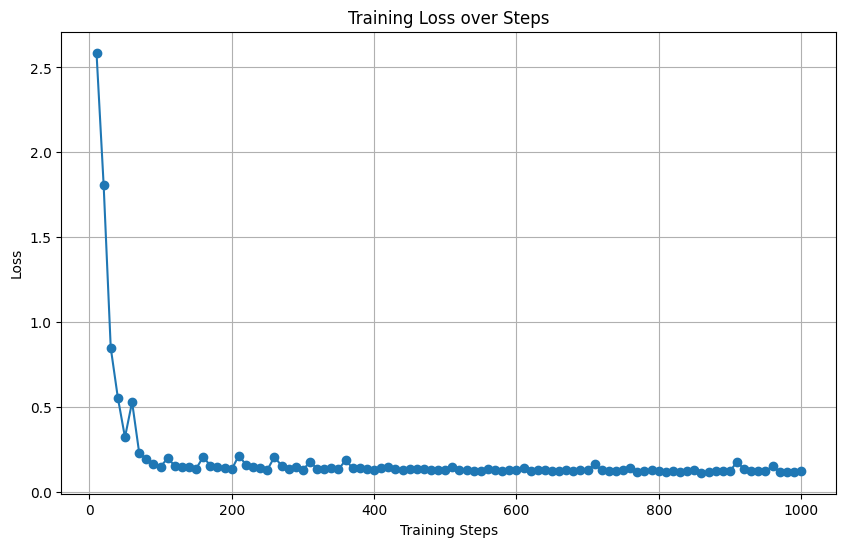

In [ ]:
# Visualization of training progress
import matplotlib.pyplot as plt

logs = trainer.state.log_history
steps = [log["step"] for log in logs if "loss" in log and "step" in log]
losses = [log["loss"] for log in logs if "loss" in log and "step" in log]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

In [ ]:
def save_merged_model(model_path, save_path):
    print(f"Creating merged model at {save_path}...")

    # Clear GPU cache before loading
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        # Load base model WITHOUT quantization for merging
        # Quantized models cannot be properly merged and saved
        print("Loading base model...")
        base_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16,  # Use float16 instead of quantization
            low_cpu_mem_usage=True
        )

        print("Loading LoRA adapter...")
        # Load the PEFT model
        model = PeftModel.from_pretrained(base_model, model_path)

        print("Merging LoRA weights with base model...")
        # Merge and unload the adapter weights
        merged_model = model.merge_and_unload()

        # Create save directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)

        print("Saving merged model...")
        # Save the merged model
        merged_model.save_pretrained(
            save_path,
            safe_serialization=True,  # Use safetensors format
            max_shard_size="5GB"  # Prevent huge single files
        )

        # Save tokenizer
        tokenizer.save_pretrained(save_path)

        print(f"Merged model saved to {save_path}")

        # Clean up memory
        del base_model, model, merged_model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return True

    except Exception as e:
        print(f"Error during model merging: {e}")
        print("Common issues:")
        print("1. Not enough GPU/RAM memory")
        print("2. Corrupted adapter weights")
        print("3. Path issues")
        return False

# Alternative function for saving quantized model (if you want to keep quantization)
def save_quantized_adapter(model_path, save_path):
    """
    Save the adapter separately (keeps quantization, smaller file size)
    Use this if you don't need a single merged model file
    """
    print(f"Saving adapter model at {save_path}...")

    try:
        # Just copy the adapter files
        import shutil
        os.makedirs(save_path, exist_ok=True)

        # Copy adapter files
        for file in os.listdir(model_path):
            if file.endswith(('.bin', '.json', '.safetensors')):
                shutil.copy2(os.path.join(model_path, file), save_path)

        # Save tokenizer
        tokenizer.save_pretrained(save_path)

        # Save a config file indicating this needs the base model
        config = {
            "base_model": MODEL_NAME,
            "adapter_path": save_path,
            "model_type": "peft_adapter"
        }

        import json
        with open(os.path.join(save_path, "adapter_config.json"), "w") as f:
            json.dump(config, f, indent=2)

        print(f"Adapter saved to {save_path}")
        print("To use this model, load the base model and then apply this adapter")
        return True

    except Exception as e:
        print(f"Error saving adapter: {e}")
        return False

# Function to test the merged model
def test_merged_model(model_path):
    """Test the merged model to make sure it works"""
    print("Testing merged model...")

    try:
        # Load the merged model
        test_model = AutoModelForCausalLM.from_pretrained(
            model_path,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16
        )

        test_tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Test generation
        test_prompt = "Xin chào, tôi cần hỗ trợ"
        inputs = test_tokenizer(test_prompt, return_tensors="pt").to(test_model.device)

        with torch.no_grad():
            outputs = test_model.generate(
                **inputs,
                max_new_tokens=50,
                temperature=0.7,
                do_sample=True,
                pad_token_id=test_tokenizer.eos_token_id
            )

        response = test_tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Test successful! Response: {response}")

        # Clean up
        del test_model, test_tokenizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return True

    except Exception as e:
        print(f"Test failed: {e}")
        return False

# Main execution
print("Starting model merging process...")

# Try to save merged model first
success = save_merged_model(OUTPUT_DIR, "/content/drive/MyDrive/Thesis/finetune_llama/llama_finetune_2")

if success:
    print("Merged model saved successfully!")

    # Test the merged model
    if test_merged_model("/content/drive/MyDrive/Thesis/finetune_llama/llama_finetune_2"):
        print("Model testing passed!")
    else:
        print("Model testing failed - check the saved model")

else:
    print("Merging failed. Trying to save as adapter instead...")
    # If merging fails, save as adapter
    adapter_success = save_quantized_adapter(OUTPUT_DIR, "/content/drive/MyDrive/Thesis/finetune_llama/llama_adapter_2")

    if adapter_success:
        print("Adapter saved successfully!")
        print("To use this model later:")
        print("1. Load the base model with quantization")
        print("2. Apply the adapter using PeftModel.from_pretrained()")
    else:
        print("Both merging and adapter saving failed!")

print("Process completed!")